# Step 2 - Build and Tune Decision Tree

Using the results of Step 1 to inform the features, I will build, train, and tune a Decision Tree Classifier model on the dataset.

### Load Data

In [21]:
import pandas as pd

# Load Titanic training data from CSV file
titanic_train = pd.read_csv('titanic_train.csv')
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [23]:
titanic_train.head(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Engineer Features

To-Do List: 

Create a binary feature for Sex where Female is 1 and Male is 0.

Calculate the total number of family members together as *PartySize*.

Calculate the total fare per family member as *PartyFare*.

Set missing Embarked values as S.  

Pull out titles as *Title*.

Fill in Null (missing) Age values using a separate predictive model.

Drop redundant and unneeded features.

In [27]:
#Create flag for missing Age values, True = Null
age_missing_mask = titanic_train['Age'].isna()
age_missing_mask[0:10]

0    False
1    False
2    False
3    False
4    False
5     True
6    False
7    False
8    False
9    False
Name: Age, dtype: bool

In [28]:
#Create flag for complete Age values, True = Value Present in original dataset
age_present_mask = ~age_missing_mask
age_present_mask[0:10]

0     True
1     True
2     True
3     True
4     True
5    False
6     True
7     True
8     True
9     True
Name: Age, dtype: bool

In [41]:
#train_wrangled['Embarked'].value_counts(dropna=False)

drop_features = ['PassengerId', 'Name', 'Sex', 'Age', 'Ticket', 'Cabin', 'CommaSplit']

train_wrangled = (titanic_train
                  .assign(Female=lambda df_: df_['Sex'].replace({'female':'1','male':'0'})
                          .astype(int),
                          PartySize = lambda df_: df_['SibSp'] + df_['Parch'] +1,
                          PartyFare = lambda df_: df_['Fare'] / df_['PartySize'],
                         Embarked = lambda df_: df_['Embarked'].fillna('S'),
                         CommaSplit = lambda df_: df_['Name'].str.split(', ',expand=True).loc[:,1],
                         Title = lambda df_: df_['CommaSplit'].str.split('.',expand=True).loc[:,0])
                  .drop(columns = drop_features)
                 )

train_wrangled.head(n=10)
                  

,Survived,Pclass,SibSp,Parch,Fare,Embarked,Female,PartySize,PartyFare,Title
0,0,3,1,0,7.2500,S,0,2,3.62500,Mr
1,1,1,1,0,71.2833,C,1,2,35.64165,Mrs
2,1,3,0,0,7.9250,S,1,1,7.92500,Miss
3,1,1,1,0,53.1000,S,1,2,26.55000,Mrs
4,0,3,0,0,8.0500,S,0,1,8.05000,Mr
5,0,3,0,0,8.4583,Q,0,1,8.45830,Mr
6,0,1,0,0,51.8625,S,0,1,51.86250,Mr
7,0,3,3,1,21.0750,S,0,5,4.21500,Master
8,1,3,0,2,11.1333,S,1,3,3.71110,Mrs
9,1,2,1,0,30.0708,C,1,2,15.03540,Mrs


### Encode Categorical Features

I am building a first model using the features that are already ready to be used, i.e. low cardinality and no missing values

In [43]:
from sklearn.preprocessing import OneHotEncoder

#Select features to use
cat_features = ['Pclass','Embarked', 'Title']

#Encode features and transform data
cat_encoder = OneHotEncoder(sparse_output = False)
cat_encoder.set_output(transform = 'pandas')

train_cat = cat_encoder.fit_transform(train_wrangled[cat_features])
train_cat.head()

,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Capt,Title_Col,Title_Don,Title_Dr,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Build Predictors DataFrame

In [45]:
#Designate numeric features 
num_features = ['SibSp','Parch','PartySize','PartyFare']

#Build data frame
titanic_X = pd.concat([train_wrangled[num_features],train_cat],axis=1)
titanic_X.head()

,SibSp,Parch,PartySize,PartyFare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,1,0,2,3.62500,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0,2,35.64165,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,0,1,7.92500,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,2,26.55000,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0,1,8.05000,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Build Age Training DataFrame

Train on the data that has a non-null Age.  

In [47]:
age_present_X = titanic_X.loc[age_present_mask,:]
age_present_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SibSp               714 non-null    int64  
 1   Parch               714 non-null    int64  
 2   PartySize           714 non-null    int64  
 3   PartyFare           714 non-null    float64
 4   Pclass_1            714 non-null    float64
 5   Pclass_2            714 non-null    float64
 6   Pclass_3            714 non-null    float64
 7   Embarked_C          714 non-null    float64
 8   Embarked_Q          714 non-null    float64
 9   Embarked_S          714 non-null    float64
 10  Title_Capt          714 non-null    float64
 11  Title_Col           714 non-null    float64
 12  Title_Don           714 non-null    float64
 13  Title_Dr            714 non-null    float64
 14  Title_Jonkheer      714 non-null    float64
 15  Title_Lady          714 non-null    float64
 16  Title_Major  

### Tune Age Model

Survived Reminder:  1 means Survived, 0 means Died.  Train a *scikit-learn* DecisionTreeRegressor model to predict the missing Age values.  Perform a grid search using various *min_samples_leaf* and *min_impurity_decrease* hyperparameters. The best model will be selected by the best *neg_mean_sqared_error*. 

In [56]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV

#Build grid search 
param_grid = {
    'min_samples_leaf': [20,22,24,26,28,30],
    'min_impurity_decrease': [0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004]}

tree = DecisionTreeRegressor(random_state = 12345)

cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 54321) 

grid_cv = GridSearchCV(tree, 
                       param_grid, 
                       scoring = 'neg_mean_squared_error', 
                       n_jobs = 5, 
                       cv = cv, 
                       refit = True)

grid_cv.fit(age_present_X, titanic_train.loc[age_present_mask,'Age']) 

#Display best parameters 
print(grid_cv.best_params_)

{'min_impurity_decrease': 0.0025, 'min_samples_leaf': 26}


### Visualize Tuned Age Model

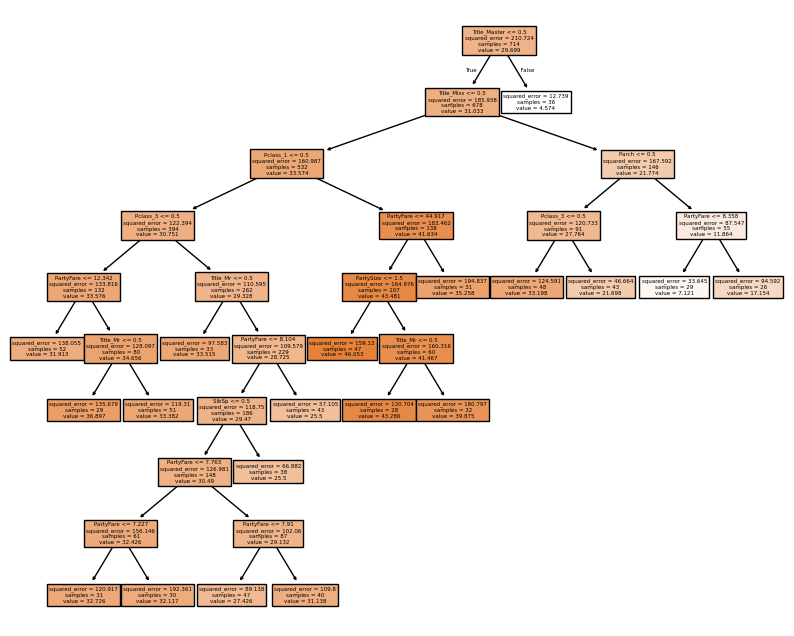

In [74]:
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree

#Fitting visual to my screen
plt.figure(figsize=(10,8))

text_rep = plot_tree(grid_cv.best_estimator_, feature_names = age_present_X.columns, filled = True)

### Evaluate Age Model

I will use *mean absolute error (MAE)* to evaluate how well the *ClassificationTreeRegressor* model is predicting the Age values.  The model's predictions are +/- 8.08 years off on average.

In [65]:
from sklearn.metrics import mean_absolute_error 

age_predictions = grid_cv.best_estimator_.predict(age_present_X)

mean_absolute_error(titanic_train.loc[age_present_mask,'Age'], age_predictions)

8.079794825220045

### Impute Null Ages 

Replace the missing null Age values with an Age predicted by the model.

In [71]:
age_predictions = grid_cv.best_estimator_.predict(titanic_X.loc[age_missing_mask,:])

train_wrangled.loc[age_missing_mask,'Age'] = age_predictions
train_wrangled.head(n=10)

,Survived,Pclass,SibSp,Parch,Fare,Embarked,Female,PartySize,PartyFare,Title,Age
0,0,3,1,0,7.2500,S,0,2,3.62500,Mr,NaN
1,1,1,1,0,71.2833,C,1,2,35.64165,Mrs,NaN
2,1,3,0,0,7.9250,S,1,1,7.92500,Miss,NaN
3,1,1,1,0,53.1000,S,1,2,26.55000,Mrs,NaN
4,0,3,0,0,8.0500,S,0,1,8.05000,Mr,NaN
5,0,3,0,0,8.4583,Q,0,1,8.45830,Mr,25.5
6,0,1,0,0,51.8625,S,0,1,51.86250,Mr,NaN
7,0,3,3,1,21.0750,S,0,5,4.21500,Master,NaN
8,1,3,0,2,11.1333,S,1,3,3.71110,Mrs,NaN
9,1,2,1,0,30.0708,C,1,2,15.03540,Mrs,NaN


### Tune Model

Survived Reminder:  1 means Survived, 0 means Died.  Train a *scikit-learn* DecisionTreeClassifier using the encoded training data to predict Survival of 1 or 0.  Perform a grid search using various *min_samples_leaf* and *min_impurity_decrease* hyperparameters. The best model will be selected by the highest *accuracy*. 

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold, GridSearchCV

#Build grid search 
param_grid = {
    'min_samples_leaf': [10,12,15,17,20,22],
    'min_impurity_decrease': [0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005]}

tree = DecisionTreeClassifier(random_state = 12345)

cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 54321) 

grid_cv = GridSearchCV(tree, 
                       param_grid, 
                       scoring = 'accuracy', 
                       n_jobs = 5, 
                       cv = cv, 
                       refit = True)

grid_cv.fit(titanic_X, titanic_train['Survived']) 

#Display best parameters 
print(grid_cv.best_params_)

{'min_impurity_decrease': 0.003, 'min_samples_leaf': 12}


Create a text and visual of the model trained with the best hyperparameter values using *Died* and *Survived* instead of 1s and 0s.   

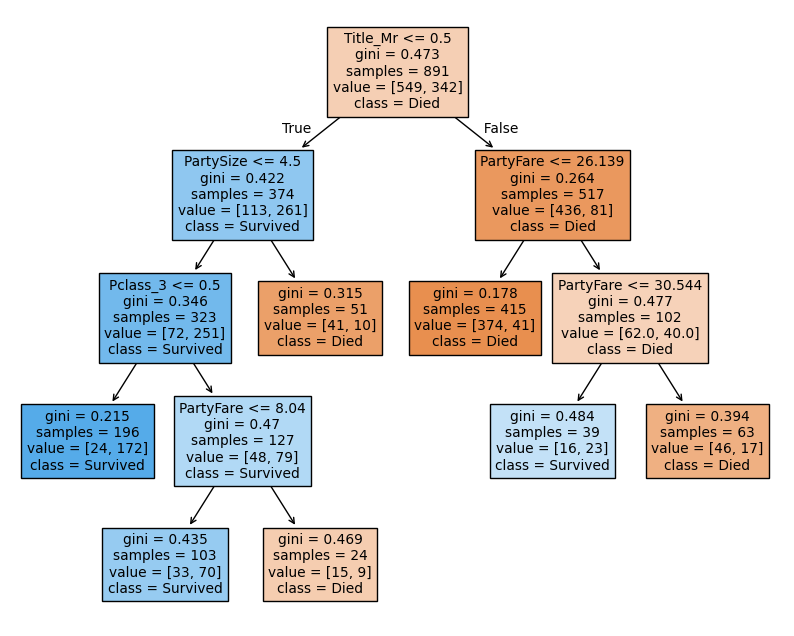

In [79]:
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree

#Fitting visual to my screen
plt.figure(figsize=(10,8))

text_rep = plot_tree(grid_cv.best_estimator_, feature_names = list(titanic_X.columns), 
                     class_names = ['Died','Survived'],filled = True)

### Evaluate Accuracy and Standard Deviation

Let's see what some statistics say about how good the model is... 

In [65]:
cv_results = pd.DataFrame(grid_cv.cv_results_).filter(like='split')
best_results = cv_results.loc[grid_cv.best_index_,:]
print(f'Mean Accuracy: {best_results.mean()}')
print(f'Accuracy Std Dev: {best_results.std()}')

Mean Accuracy: 0.8238976279650437
Accuracy Std Dev: 0.03964376608958374


Model Bias: 82.4% (mean accuracy), decent
Model Variance: 4.0% (standard deviation), high